## Bibliotecas

In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Estimativa da memória

- O ambiente utilizado para essa execução é um WSL com Ubunto como OS
- No momento da execução, há MemFree é a quantidade de memória livre, do total (MemTotal) do sistema

O Valor da memória livre varia dependendo dos programas em execução

In [70]:
with open("/proc/meminfo", 'r') as memory_status:
    lines = memory_status.readlines()
    memtotal = int(lines[0].split('kB')[0].split(':')[1])
    memfree = int(lines[1].split('kB')[0].split(':')[1])
    print(lines[0])
    print(lines[1])
    

MemTotal:       16469120 kB

MemFree:        13079732 kB



O consumo de memória dos programa se dá, manjoritariamente, pela alocação da matriz, ou seja, complexidade de espaço $O(n^2)$. Dessa forma, assumindo que os programas só utilizarão a RAM disponível, temos que:

$$
    n_{max}^2  \cdot size(e) \leq mfree \\
   
$$
$$
 n_{max} \leq \sqrt{\frac{mfree}{size(e)}}
$$

Sendo $n_{max}$ o tamanho máximo da dimensão da matriz, $size(e)$ o número de bytes necessários para armazenar um elemento da matriz e  $mfree$ a quantidade de memória livre em bytes.


Nesse sentindo, supondo que a memória impressa anteriormente estará livre e disponível para a alocação pelo programador, no momento da execução do programa, teríamos os seguintes valores de $n_{max}$ para Fortran utilizando tipo $Real$ ( $size(e) = 4$) e para C utilizando tipo $float$ ($size(e) = 4$).


In [71]:
n_max = round(np.sqrt(memfree*1000/4))
n_max

57183

- Vamos testar o programas para várias dimensões $n$, aumentando-as de 1000 unidades a cada passo até chegar no máximo estimado. Isso vai nos dar 57 pontos para a curva.

In [95]:
n_max/1000

57.183

## Estimativa de Tempo para cada N

### Para o programa em Fortran
<hr/>

- Sem inverter o loop

In [7]:
csv_file = 'results/fortran_lines_first.csv'
with open(csv_file, 'a') as f:
    f.write('n,tempo\n')

In [51]:
for n in range(1000, n_max, 1000):
    try:
        out = subprocess.check_output(["./src/program2.out", f'{n}', '0'])
    except subprocess.CalledProcessError as e:
        print(e.output)
        break
    else: 
        with open(csv_file, 'a') as f:
            f.write(f'{n}, {float(out)}\n')

- Invertendo o loop

In [96]:
csv_file = 'results/fortran_columns_first.csv'
with open(csv_file, 'a') as f:
    f.write('n,tempo\n')

In [ ]:
for n in range(1000, n_max, 1000):
    try:
        out = subprocess.check_output(["./src/program2.out", f'{n}', '1'])
    except subprocess.CalledProcessError as e:
        print(e.output)
        break
    else: 
        with open(csv_file, 'a') as f:
            f.write(f'{n}, {float(out)}\n')

### Para o programa em C
<hr/>

- Sem inverter o loop

In [ ]:
csv_file = 'results/c_lines_first.csv'
with open(csv_file, 'a') as f:
    f.write('n,tempo\n')

In [ ]:
for n in range(1000, n_max, 1000):
    try:
        out = subprocess.check_output(["./src/program2.out", f'{n}', '0'])
    except subprocess.CalledProcessError as e:
        print(e.output)
        break
    else: 
        with open(csv_file, 'a') as f:
            f.write(f'{n}, {float(out)}\n')

b''


- Invertendo o loop

In [ ]:
csv_file = 'results/c_columns_first.csv'
with open(csv_file, 'a') as f:
    f.write('n,tempo\n')

In [ ]:
for n in range(1000, n_max, 1000):
    try:
        out = subprocess.check_output(["./src/program2.out", f'{n}', '1'])
    except subprocess.CalledProcessError as e:
        print(e.output)
        break
    else: 
        with open(csv_file, 'a') as f:
            f.write(f'{n}, {float(out)}\n')

## Análise


In [91]:
fortran_cl = pd.read_csv('results/fortran_columns_first.csv')


In [92]:
fortran_cl

,1000,0.0
0,2000,0.031250
1,3000,0.046875
2,4000,0.062500
3,5000,0.093750
4,6000,0.140625
5,7000,0.203125
6,8000,0.265625
7,9000,0.296875
8,10000,0.453125
9,11000,0.484375


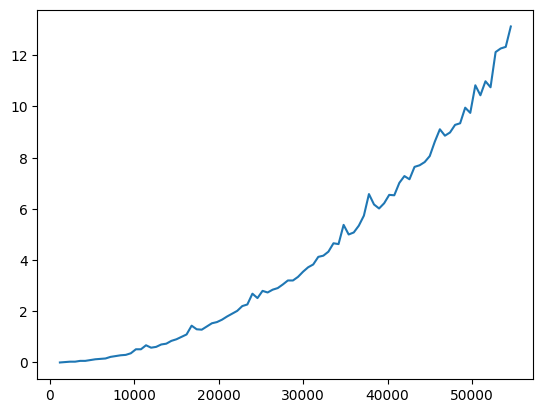

In [94]:
plt.plot(np.array(teste['n'].to_list()), np.array(teste['tempo'].to_list()))

In [11]:
fortran_cl = pd.read_csv('results/fortran_cl.csv')

fortran_lc = pd.read_csv('results/fortran_lc.csv')


In [22]:
c_cl = pd.read_csv('results/c_cl.csv')

c_lc = pd.read_csv('results/c_lc.csv')


In [23]:
n_log = np.log2(np.array(fortran_cl['n'].to_list()))
fortran_cl_time = np.array(fortran_cl['tempo'].to_list())
fortran_lc_time = np.array(fortran_lc['tempo'].to_list())
c_cl_time = np.array(c_cl['tempo'].to_list())
c_lc_time = np.array(c_lc['tempo'].to_list())


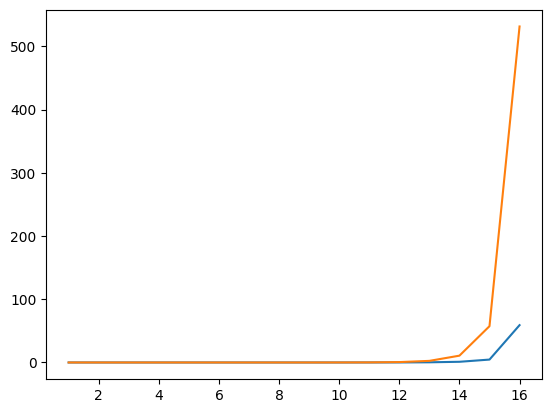

In [21]:
plt.plot(n_log, fortran_cl_time)
plt.plot(n_log, fortran_lc_time)

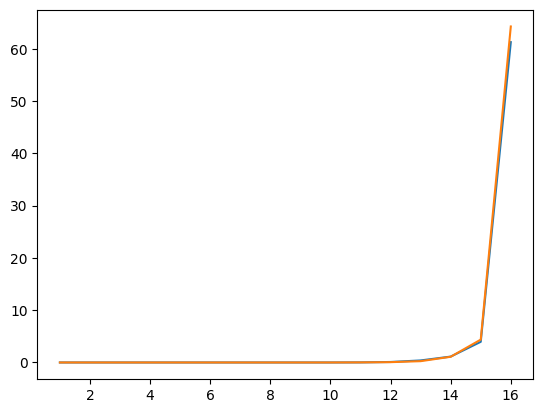

In [24]:
plt.plot(n_log, c_cl_time)
plt.plot(n_log, c_lc_time)

/tmp/ipykernel_245/661388730.py:1: RuntimeWarning: divide by zero encountered in log2
  plt.plot(n_log, np.log2(fortran_cl_time))
/tmp/ipykernel_245/661388730.py:2: RuntimeWarning: divide by zero encountered in log2
  plt.plot(n_log, np.log2(fortran_lc_time))


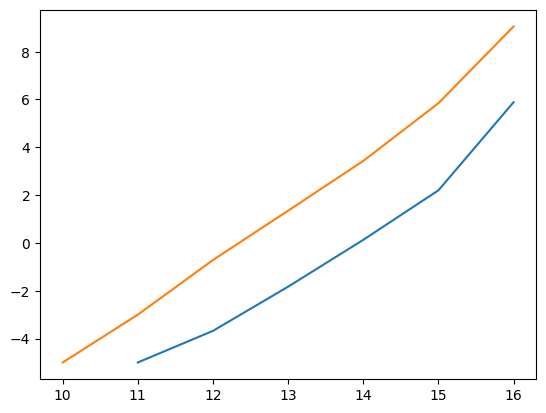

In [28]:
plt.plot(n_log, np.log2(fortran_cl_time))
plt.plot(n_log, np.log2(fortran_lc_time))